# Modelling and Evaluation Notebook

---

## Objectives
* The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.
## Inputs
* inputs/datasets/raw/cherry-leaves/test
* inputs/datasets/raw/cherry-leaves/train
* inputs/datasets/raw/cherry-leaves/validation
* image shape embeddings
## Outputs
## Additional Comments
* No additional comments

---

## Import regular packages

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Set Working Directory

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detection'

---

## Set input directory

In [5]:
my_data_dir = 'inputs/datasets/raw/cherry-leaves'
test_path = my_data_dir + '/test'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'

## Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set label names

In [7]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Number of images in train, test and validation data


* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




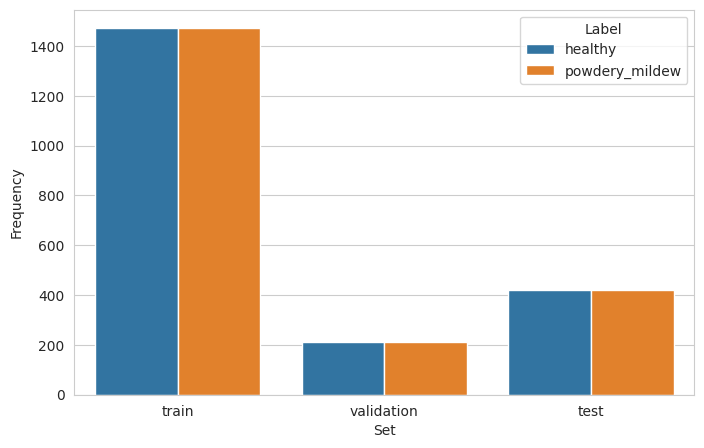

In [11]:
import pandas as pd

data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

folders = ['train', 'validation', 'test']

for folder in folders:
    for label in labels:
        row = {
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))  
        }
        for key, value in row.items():
            data[key].append(value)
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

df_freq = pd.DataFrame(data)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image Data Augmentation

---

## ImageDataGenerator

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-01-10 15:03:23.601489: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Initialize ImageDataGenerator

In [13]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

## Augment training, test and validation image datasets

In [14]:
batch_size = 20 
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [15]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [16]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training, test and validation images

(20, 256, 256, 3)


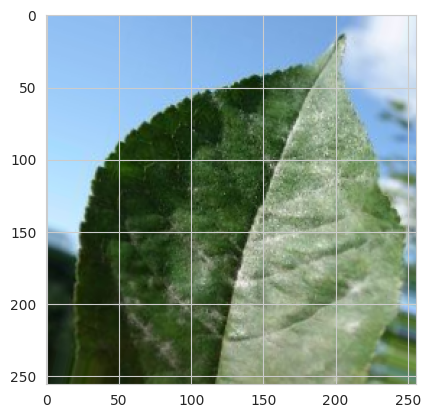

(20, 256, 256, 3)


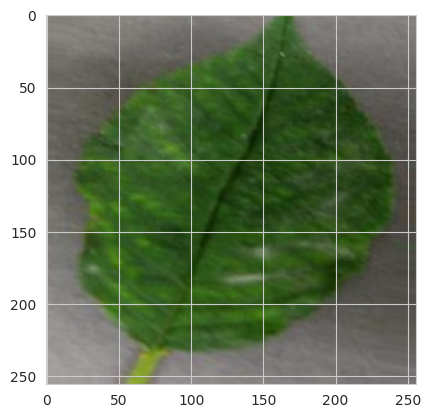

(20, 256, 256, 3)


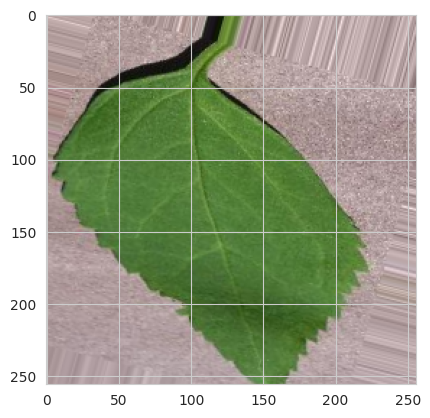

In [17]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


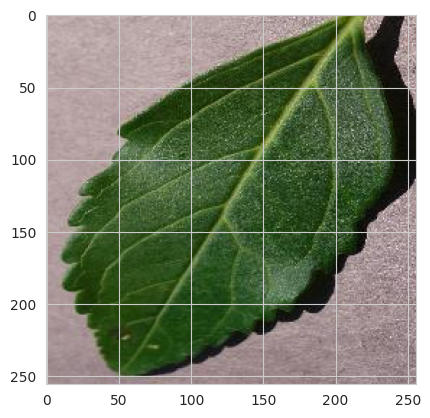

(20, 256, 256, 3)


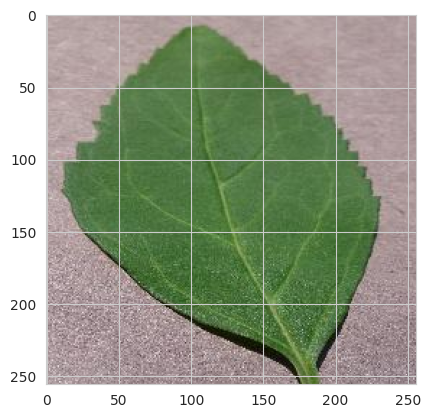

(20, 256, 256, 3)


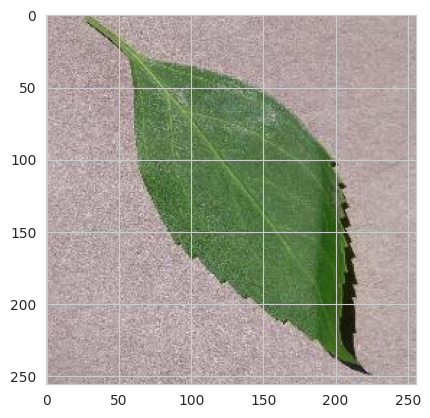

In [18]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


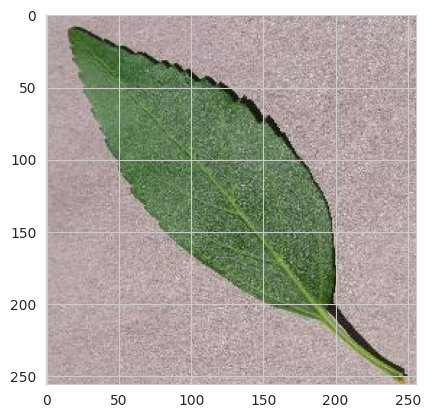

(20, 256, 256, 3)


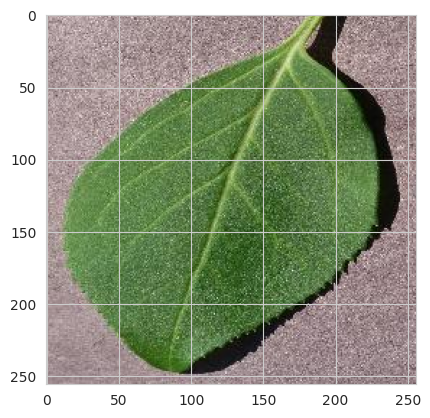

(20, 256, 256, 3)


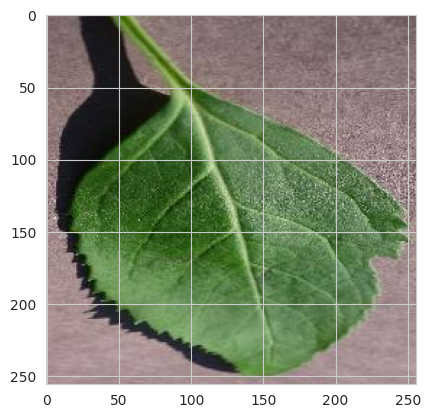

In [19]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

Save class_indices

In [20]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model creation

---

## ML model
Import model packages

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

Model

In [30]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

Model summary

In [31]:
create_tf_model().summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,429,377 (28.34 MB)

 Trainable params: 7,429,377 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

Early stopping

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

Fit model for model training

In [33]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.7408 - loss: 0.5081 - val_accuracy: 0.9071 - val_loss: 0.2289
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8500 - loss: 0.3547 - val_accuracy: 0.9024 - val_loss: 0.2725
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9758 - loss: 0.1085 - val_accuracy: 0.9786 - val_loss: 0.1086
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 1.0000 - loss: 0.0329 - val_accuracy: 0.9762 - val_loss: 0.1120
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.9858 - loss: 0.0525 - val_accuracy: 0.9833 - val_loss: 0.0657
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 1.0000 - loss: 0.0215 - val_accuracy: 0.9810 - val_loss: 0.0918
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9870 - loss: 0.0419 - val_accuracy: 0.9929 - val_loss: 0.0286
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accu

Save model

In [34]:
model.save('outputs/v1/mildew_detector_model.keras')

---

# Model Performance

---

## Model learning curve

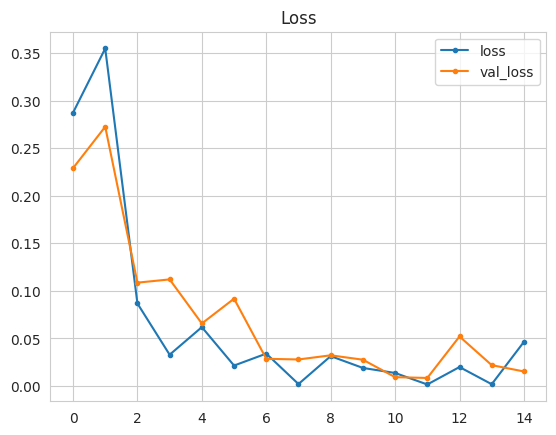

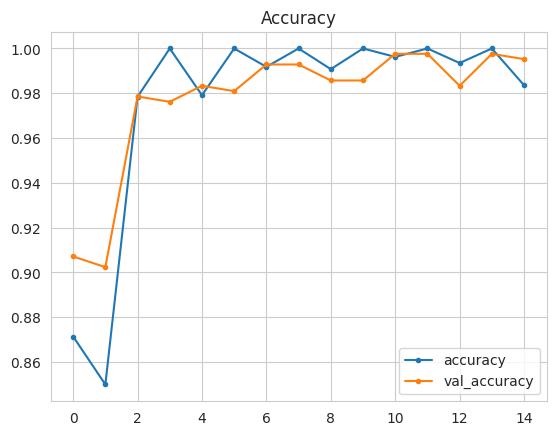

In [35]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

In [37]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detector_model.keras')

In [38]:
evaluation = model.evaluate(test_set)

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 260ms/step - accuracy: 0.9977 - loss: 0.0048


## Save evaluation pickle

In [39]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predict on new data

Load a random image

Image shape: (256, 256), Image mode: RGB


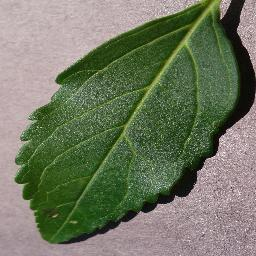

In [52]:
from tensorflow.keras.preprocessing import image

pointer = 17
label = labels[0]

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [53]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probablities

In [54]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0.9999999992687072
healthy


---

## Push files to Repo

In [55]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

In [56]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   jupyter_notebooks/Data_collection.ipynb
	modified:   jupyter_notebooks/Data_visualization.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	jupyter_notebooks/Modelling_and_Evaluating.ipynb
	outputs/v1/class_indices.pkl
	outputs/v1/evaluation.pkl
	outputs/v1/labels_distribution.png
	outputs/v1/mildew_detector_model.h5
	outputs/v1/mildew_detector_model.keras
	outputs/v1/model_training_acc.png
	outputs/v1/model_training_losses.png

no changes added to commit (use "git add" and/or "git commit -a")


In [57]:
!git add .

In [58]:
!git commit -am " Add new plots"

[main eeb10b3]  Add new plots
 10 files changed, 1441 insertions(+), 1 deletion(-)
 create mode 100644 jupyter_notebooks/Modelling_and_Evaluating.ipynb
 create mode 100644 outputs/v1/class_indices.pkl
 create mode 100644 outputs/v1/evaluation.pkl
 create mode 100644 outputs/v1/labels_distribution.png
 create mode 100644 outputs/v1/mildew_detector_model.h5
 create mode 100644 outputs/v1/mildew_detector_model.keras
 create mode 100644 outputs/v1/model_training_acc.png
 create mode 100644 outputs/v1/model_training_losses.png


In [59]:
!git push

Enumerating objects: 21, done.
Counting objects: 100% (21/21), done.
Delta compression using up to 16 threads
Compressing objects: 100% (12/12), done.
Writing objects: 100% (15/15), 141.22 MiB | 11.11 MiB/s, done.
Total 15 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
remote: warning: See https://gh.io/lfs for more information.
remote: warning: File outputs/v1/mildew_detector_model.h5 is 85.07 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: File outputs/v1/mildew_detector_model.keras is 85.07 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
To https://github.com/TomH131/mildew-detection.git
   a4852d5..eeb10b3  main -> main
